# Modeling

In this notebook, I create different types of models that attempt to predict attendance of MLS matches.

Types of models:

1. Linear Regression
2. XGBoost Regression
3. Random Forest Regression
4. K Nearest Neighbors

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

In [2]:
# Read in data
mlsall_df = pd.read_csv('mls_with_weather.csv', index_col=0)
mlsall_df

,round,day,date,local_time,home_team,home_score,away_score,away_team,attendance,stadium,...,snow,cloudcover,windspeed,windgust,rain_sum,snow_sum,date_year,date_month,date_day,home_opener
0,Regular Season,Sat,2018-03-03,13.0,27,0,2,6,26633,BMO Field,...,0.0,1.0,21.6,42.5,0.0,0.00,2018,3,3,1
1,Regular Season,Sat,2018-03-03,14.5,9,4,0,0,20377,BBVA Compass Stadium,...,0.0,40.0,13.6,23.4,0.0,0.00,2018,3,3,1
2,Regular Season,Sun,2018-03-04,14.0,24,0,1,11,40070,CenturyLink Field,...,0.0,27.0,7.2,18.0,0.0,0.00,2018,3,4,1
3,Regular Season,Sun,2018-03-04,15.0,28,2,1,14,27837,BC Place,...,0.0,65.0,7.6,15.5,0.0,0.00,2018,3,4,1
4,Regular Season,Sat,2018-03-03,19.0,20,2,0,16,16452,Talen Energy Stadium,...,0.0,14.0,27.3,61.9,0.0,0.91,2018,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2280,Regular Season,Sat,2023-10-21,19.0,5,0,1,22,17538,Dick's Sporting Goods Park,...,0.0,18.0,8.7,24.8,0.0,0.00,2023,10,21,0
2281,Regular Season,Sat,2023-10-21,20.0,26,0,2,24,22423,Citypark,...,0.0,0.0,22.4,45.4,0.0,0.00,2023,10,21,0
2282,Regular Season,Sat,2023-10-21,20.0,25,3,1,12,20479,Children's Mercy Park,...,0.0,0.0,14.0,30.2,0.0,0.00,2023,10,21,0
2283,Wild Card Round,Wed,2023-10-25,19.5,18,5,2,2,16074,Red Bull Arena,...,NaN,NaN,NaN,NaN,NaN,NaN,2023,10,25,0


Below, I drop matches for which weather data is missing and the attendance is 0. If the attendance is 0, it either means the information was missing or fans were not allowed due to the pandemic.

In [3]:
# Drop anything with missing data
mlsall_df.dropna(inplace=True)
# Drop matches with attendance=0
mlsall_df.drop(mlsall_df[mlsall_df['attendance']==0].index, inplace=True)
mlsall_df

,round,day,date,local_time,home_team,home_score,away_score,away_team,attendance,stadium,...,snow,cloudcover,windspeed,windgust,rain_sum,snow_sum,date_year,date_month,date_day,home_opener
0,Regular Season,Sat,2018-03-03,13.0,27,0,2,6,26633,BMO Field,...,0.0,1.0,21.6,42.5,0.0,0.00,2018,3,3,1
1,Regular Season,Sat,2018-03-03,14.5,9,4,0,0,20377,BBVA Compass Stadium,...,0.0,40.0,13.6,23.4,0.0,0.00,2018,3,3,1
2,Regular Season,Sun,2018-03-04,14.0,24,0,1,11,40070,CenturyLink Field,...,0.0,27.0,7.2,18.0,0.0,0.00,2018,3,4,1
3,Regular Season,Sun,2018-03-04,15.0,28,2,1,14,27837,BC Place,...,0.0,65.0,7.6,15.5,0.0,0.00,2018,3,4,1
4,Regular Season,Sat,2018-03-03,19.0,20,2,0,16,16452,Talen Energy Stadium,...,0.0,14.0,27.3,61.9,0.0,0.91,2018,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278,Regular Season,Sat,2023-10-21,18.0,21,1,3,9,25218,Providence Park,...,0.0,100.0,3.2,14.0,0.0,0.00,2023,10,21,0
2279,Regular Season,Sat,2023-10-21,18.0,28,1,1,11,25146,BC Place Stadium,...,0.0,93.0,4.4,11.9,0.0,0.00,2023,10,21,0
2280,Regular Season,Sat,2023-10-21,19.0,5,0,1,22,17538,Dick's Sporting Goods Park,...,0.0,18.0,8.7,24.8,0.0,0.00,2023,10,21,0
2281,Regular Season,Sat,2023-10-21,20.0,26,0,2,24,22423,Citypark,...,0.0,0.0,22.4,45.4,0.0,0.00,2023,10,21,0


After dropping no weather, no attendance matches, there are 2229 matches remaining.

In [4]:
# Get data types of each column
mlsall_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2229 entries, 0 to 2282
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   round             2229 non-null   object 
 1   day               2229 non-null   object 
 2   date              2229 non-null   object 
 3   local_time        2229 non-null   float64
 4   home_team         2229 non-null   int64  
 5   home_score        2229 non-null   int64  
 6   away_score        2229 non-null   int64  
 7   away_team         2229 non-null   int64  
 8   attendance        2229 non-null   int64  
 9   stadium           2229 non-null   object 
 10  latitude          2229 non-null   float64
 11  longitude         2229 non-null   float64
 12  playoff           2229 non-null   int64  
 13  att_div_capacity  2229 non-null   float64
 14  real_home_team    2229 non-null   int64  
 15  same_conf         2229 non-null   int64  
 16  rivals            2229 non-null   int64  
 17  

**Target variable**

There are two options for the target variable: attendance and attendance/capacity. I plan on using home team and away team as categorical parameters in the model, so even if I choose to use raw attendance, there will be parameters that effectively normalize the attendance per team. Therefore, I will use raw attendance as the target variable.

In [5]:
# Target variable
#y = mlsall_df['att_div_capacity']
y = mlsall_df['attendance']

**Preparing data for linear regression**

The way I am going to create the linear regression model is by iteratively trying different combinations of inputs and evaluating the success of the model based on the RMSE of the residuals and the R-squared of the fit.

In [6]:
def create_X(df, columns, add_constant=False):
    """
    Create a DataFrame to use as input to a model.
    
    Options for columns:
    'home_team',
    'away_team',
    'day',
    'date_month',
    'date_year',
    'local_time',
    'real_home_team',
    'playoff',
    'home_opener',
    'rivals',
    'rain_sum',
    'snow_sum',
    'temperature',
    'windspeed'
    
    Certain columns will be turned into categorical variables.
    All of that work is automatically handled below.
    
    Options:
    add_constant: If True, a constant column will be added. Default is False.
    """
    # Check to make sure all entries in columns are valid
    for word in columns:
        if word not in df.columns:
            print(f"Error: {word} is not in the DataFrame.")
            return
    
    # Start with DataFrame containing everything that might be needed
    X = df.copy()[columns]
    
    # Create constant column
    if add_constant:
        X['const'] = 1
    
    # Create categorical variables for home team and away team
    if 'home_team' in columns:
        X = pd.get_dummies(X, columns=['home_team'], drop_first=True, dtype=int)
    if 'away_team' in columns:
        X = pd.get_dummies(X, columns=['away_team'], drop_first=True, dtype=int)
        
    # Create categories for day of the week
    if 'day' in columns:
        X = pd.get_dummies(X, columns=['day'], drop_first=False, dtype=int)
        # Drop Saturday
        X.drop(columns='day_Sat', inplace=True)
    
    # Create categories for year
    if 'date_year' in columns:
        X = pd.get_dummies(X, columns=['date_year'], drop_first=True, dtype=int)
        
    # Create column that indicates if it rained before or during the match
    if 'rain' in columns:
        X['rain_yn'] = df[['rain','rain_sum']].apply(lambda x: 0 if (x.rain==0)&(x.rain_sum==0) else 1, axis=1)
        X.drop(columns='rain', inplace=True)
        
    # Create column that indicates if it snowed before or during the match
    if 'snow' in columns:
        X['snow_yn'] = df[['snow','snow_sum']].apply(lambda x: 0 if (x.snow==0)&(x.snow_sum==0) else 1, axis=1)
        X.drop(columns='snow', inplace=True)

    # Create categories for temperature
    if 'temperature' in columns:
        # The temperature is considered cold if below 40
        X['cold'] = X['temperature'].apply(lambda x: 1 if x<40 else 0)
        # The temperature is considered hot if above 90
        X['hot'] = X['temperature'].apply(lambda x: 1 if x>90 else 0)
        X.drop(columns='temperature', inplace=True)
        
    # Create categories for kick off time
    if 'local_time' in columns:
        X['time_categ'] = X['local_time'].apply(lambda x: 1 if x >= 20 else 0) + \
        X['local_time'].apply(lambda x: 1 if x >= 17 else 0) + \
        X['local_time'].apply(lambda x: 1 if x >= 14 else 0)
        
        X.drop(columns='local_time', inplace=True)
        X = pd.get_dummies(X, columns=['time_categ'], drop_first=True, dtype=int)
        
    # Subtract 7 from the month so that the reference month is July (middle of season)
    if 'date_month' in columns:
        X['date_month'] = X['date_month'].apply(lambda x: x-7)
        
    # Any other columns listed are already in the correct form for the model
        
    return X

Below is a function for getting the RMSE of the residuals, the central 68.3% interval of the residuals, and the R-squared value. Smaller values imply better fits.

In [22]:
def evaluate_linear_model(model, X, y):
    """
    This function takes the results of a model and calculates the following metrics:
    RMSE of the residuals
    The central 68.3% interval of the residuals.
    The R-squared value.
    
    It also makes a plot of predicted vs. actual attendance.
    """
    # RMSE of residuals
    print(f"RMSE of residuals: {np.sqrt(model.mse_resid)}")

    # Central 68.3% interval
    print(f"68.3% interval: {np.quantile(model.resid, 0.1585)} {np.quantile(model.resid, 0.8415)}")
    print(f"Width of 68.3% interval: {np.quantile(model.resid, 0.8415)-np.quantile(model.resid, 0.1585)}")
    
    # R-squared value
    print(f"R-squared: {model.rsquared}")
    
    fig, ax = plt.subplots(figsize=(5,5))

    ax.scatter(model.predict(X),
               y,
               alpha=0.5,
               s=7)

    ax.plot([0,80000],[0,80000],color='black')

    ax.set_xlabel('Predicted attendance')
    ax.set_ylabel('Actual attendance')

**Model 1**

To start, I will just fit a single constant to the data.

In [8]:
X = create_X(mlsall_df, columns=[], add_constant=True)
linreg = sm.OLS(y,X).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             attendance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 03 Nov 2023   Prob (F-statistic):                nan
Time:                        13:24:47   Log-Likelihood:                -23554.
No. Observations:                2229   AIC:                         4.711e+04
Df Residuals:                    2228   BIC:                         4.712e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.082e+04    199.049    104.579      0.000    2.04e+04    2.12e+04
==============================================================================
Omnibus:                     1176.355   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9640.591
Skew:                           2.370   Prob(JB):                         0.00
Kurtosis:                      12.019   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

RMSE of residuals: 9397.534829728174
68.3% interval: -6729.380888290711 4708.96311170929
Width of 68.3% interval: 11438.344000000001
R-squared: 1.1102230246251565e-16


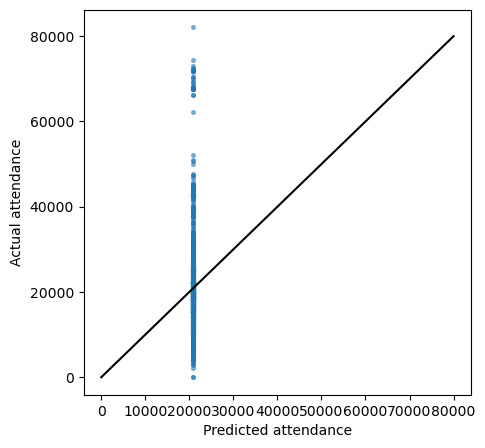

In [9]:
evaluate_linear_model(results, X, y)

This model predicts 20,816 for each match. Not surprisingly, this is a pretty bad fit as it does not account for any of the trends in the data.

The RMSE for this fit was 9,398. The goal of subsequent models will be to reduce this number.

**Model 2**

This model will add home and away team parameters. I expect this to improve the fit quite a lot because it will account for differences in stadium capacities.

In [10]:
X = create_X(mlsall_df, columns=['home_team','away_team'], add_constant=True)
linreg = sm.OLS(y,X).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             attendance   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     75.95
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        13:25:27   Log-Likelihood:                -22345.
No. Observations:                2229   AIC:                         4.480e+04
Df Residuals:                    2172   BIC:                         4.513e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4.969e+04    845.914     58.746      0.000     4.8e+04    5.14e+04
home_team_1  -2.913e+04    972.269    -29.963      0.000    -3.1e+04   -2.72e+04
home_team_2  -1.374e+04   1114.164    -12.335      0.000   -1.59e+04   -1.16e+04
home_team_3  -3.526e+04    836.884    -42.134      0.000   -3.69e+04   -3.36e+04
home_team_4  -2.557e+04    889.326    -28.756      0.000   -2.73e+04   -2.38e+04
home_team_5  -3.545e+04    856.805    -41.371      0.000   -3.71e+04   -3.38e+04
home_team_6  -3.303e+04    834.050    -39.598      0.000   -3.47e+04   -3.14e+04
home_team_7  -3.411e+04    844.053    -40.408      0.000   -3.58e+04   -3.25e+04
home_team_8  -3.335e+04    834.487    -39.961      0.000    -3.5e+04   -3.17e+04
home_team_9  -3.454e+04    849.717    -40.649      0.000   -3.62e+04   -3.29e+04
home_team_10 -2.754e+04    847.290    -32.506      0.000   -2.92e+04   -2.59e+04
home_team_11 -2.823e+04    835.679    -33.782      0.000   -2.99e+04   -2.66e+04
home_team_12 -3.017e+04    846.290    -35.652      0.000   -3.18e+04   -2.85e+04
home_team_13 -3.491e+04    976.406    -35.759      0.000   -3.68e+04    -3.3e+04
home_team_14 -3.263e+04    878.557    -37.144      0.000   -3.44e+04   -3.09e+04
home_team_15 -2.466e+04    964.828    -25.561      0.000   -2.66e+04   -2.28e+04
home_team_16 -2.992e+04    844.586    -35.427      0.000   -3.16e+04   -2.83e+04
home_team_17 -3.123e+04    830.212    -37.622      0.000   -3.29e+04   -2.96e+04
home_team_18 -3.224e+04    840.056    -38.383      0.000   -3.39e+04   -3.06e+04
home_team_19 -2.989e+04    837.533    -35.684      0.000   -3.15e+04   -2.82e+04
home_team_20 -3.282e+04    822.587    -39.898      0.000   -3.44e+04   -3.12e+04
home_team_21 -2.672e+04    849.975    -31.431      0.000   -2.84e+04    -2.5e+04
home_team_22 -3.152e+04    844.718    -37.310      0.000   -3.32e+04   -2.99e+04
home_team_23 -3.276e+04    859.955    -38.097      0.000   -3.44e+04   -3.11e+04
home_team_24 -1.493e+04    838.042    -17.811      0.000   -1.66e+04   -1.33e+04
home_team_25 -3.083e+04    847.915    -36.360      0.000   -3.25e+04   -2.92e+04
home_team_26 -2.742e+04   1474.258    -18.598      0.000   -3.03e+04   -2.45e+04
home_team_27 -2.679e+04    845.206    -31.691      0.000   -2.84e+04   -2.51e+04
home_team_28 -3.195e+04    867.993    -36.814      0.000   -3.37e+04   -3.03e+04
away_team_1  -1344.9175   1000.817     -1.344      0.179   -3307.576     617.741
away_team_2    452.9537   1135.263      0.399      0.690   -1773.361    2679.268
away_team_3     25.1099    853.860      0.029      0.977   -1649.357    1699.577
away_team_4   -543.4853    908.364     -0.598      0.550   -2324.839    1237.869
away_team_5   -898.9510    863.621     -1.041      0.298   -2592.561     794.658
away_team_6    -62.3314    851.065     -0.073      0.942   -1731.317    1606.655
away_

RMSE of residuals: 5533.834547035362
68.3% interval: -3958.5249405161753 3203.8241877458277
Width of 68.3% interval: 7162.349128262003
R-squared: 0.6619592263521832


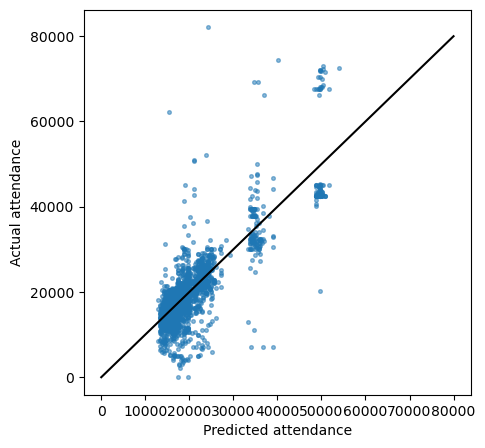

In [11]:
evaluate_linear_model(results, X, y)

Accounting for the teams involved in the match improved the fit. The RMSE of the residuals dropped from 9,398 to 5,534.

The R-squared is now at 0.662. The parameters for home and away team will be kept for all subsequent models.

For note, the constant in the fit (49,694) is a lot higher than it was for model 1. This is because the new variables are all in reference to Atlanta United which has the highest average attendance for its home matches. This does strangely mean that the constant assumes a match between Atlanta and Atlanta, but that is not actually a problem.

**Model 3**

In this model, I incorporate a few time-based parameters:
1. Day of the week
2. Month (reference case is a match in July)
3. Local time of kick off (categorical)
4. Year (2018 is reference case)

In [12]:
X = create_X(mlsall_df,
             columns=['home_team','away_team',
                      'day','date_month','local_time','date_year'],
             add_constant=True)
linreg = sm.OLS(y,X).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             attendance   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     82.59
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        13:26:31   Log-Likelihood:                -22102.
No. Observations:                2229   AIC:                         4.435e+04
Df Residuals:                    2158   BIC:                         4.475e+04
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
date_month       543.4748     49.962     10.878      0.000     445.495     641.454
const           5.154e+04    900.852     57.217      0.000    4.98e+04    5.33e+04
home_team_1    -2.782e+04    897.522    -30.995      0.000   -2.96e+04   -2.61e+04
home_team_2    -1.407e+04   1017.085    -13.833      0.000   -1.61e+04   -1.21e+04
home_team_3    -3.478e+04    759.468    -45.797      0.000   -3.63e+04   -3.33e+04
home_team_4    -2.504e+04    809.501    -30.935      0.000   -2.66e+04   -2.35e+04
home_team_5    -3.543e+04    777.777    -45.547      0.000    -3.7e+04   -3.39e+04
home_team_6    -3.283e+04    757.503    -43.337      0.000   -3.43e+04   -3.13e+04
home_team_7    -3.392e+04    766.275    -44.272      0.000   -3.54e+04   -3.24e+04
home_team_8    -3.306e+04    762.564    -43.358      0.000   -3.46e+04   -3.16e+04
home_team_9    -3.422e+04    771.749    -44.338      0.000   -3.57e+04   -3.27e+04
home_team_10   -2.729e+04    769.556    -35.465      0.000   -2.88e+04   -2.58e+04
home_team_11   -2.795e+04    759.683    -36.791      0.000   -2.94e+04   -2.65e+04
home_team_12   -3.004e+04    765.657    -39.232      0.000   -3.15e+04   -2.85e+04
home_team_13   -3.343e+04    897.698    -37.244      0.000   -3.52e+04   -3.17e+04
home_team_14   -3.353e+04    797.633    -42.038      0.000   -3.51e+04    -3.2e+04
home_team_15   -2.333e+04    878.396    -26.565      0.000   -2.51e+04   -2.16e+04
home_team_16    -2.98e+04    767.865    -38.806      0.000   -3.13e+04   -2.83e+04
home_team_17   -3.093e+04    752.882    -41.079      0.000   -3.24e+04   -2.95e+04
home_team_18   -3.231e+04    761.740    -42.410      0.000   -3.38e+04   -3.08e+04
home_team_19    -2.96e+04    759.055    -38.999      0.000   -3.11e+04   -2.81e+04
home_team_20   -3.254e+04    744.693    -43.697      0.000    -3.4e+04   -3.11e+04
home_team_21   -2.691e+04    770.191    -34.940      0.000   -2.84e+04   -2.54e+04
home_team_22   -3.126e+04    775.683    -40.301      0.000   -3.28e+04   -2.97e+04
home_team_23   -3.274e+04    780.229    -41.967      0.000   -3.43e+04   -3.12e+04
home_team_24   -1.463e+04    767.928    -19.051      0.000   -1.61e+04   -1.31e+04
home_team_25   -3.084e+04    766.495    -40.230      0.000   -3.23e+04   -2.93e+04
home_team_26   -2.827e+04   1348.376    -20.963      0.000   -3.09e+04   -2.56e+04
home_team_27   -2.681e+04    766.241    -34.986      0.000   -2.83e+04   -2.53e+04
home_team_28   -3.221e+04    786.050    -40.971      0.000   -3.37e+04   -3.07e+04
away_team_1     -623.9779    908.954     -0.686      0.492   -2406.495    1158.539
away_team_2     -159.2121   1033.821     -0.154      0.878   -2186.601    1868.177
away_team_3      -95.9110    771.111     -0.124      0.901   -1608.110    1416.288
away_team_4     -403.8202    823.049     -0.491      0.624   -2017.872    1210.232
away_team_5 

RMSE of residuals: 4978.200192318331
68.3% interval: -3408.3698999595977 3046.588216390708
Width of 68.3% interval: 6454.958116350306
R-squared: 0.7281977294597555


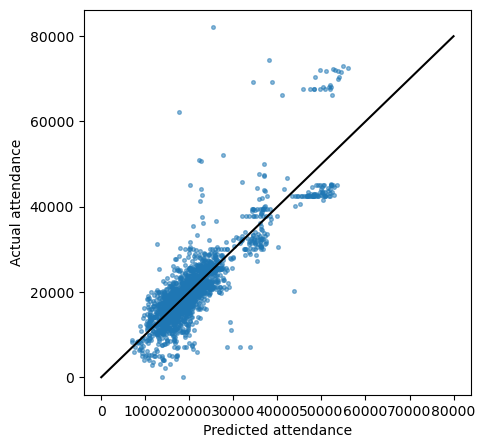

In [13]:
evaluate_linear_model(results, X, y)

The fit improved a bit. The R-squared is now 0.728 and the RMSE is 4,978.

Day of the week: All of the parameters for day of the week were negative, indicating that Saturday is the best day to hold matches. However, only Tuesday and Wednesday had p-values below 0.05. The result for Wednesday is quite telling. MLS holds a lot of matches on Wednesdays, but the model here indicates that those matches expect over 3000 fewer attendees than on Saturdays.

Month: The one month parameter is statistically significant according to the p-value. The value of the parameter is 543, which means that attendance goes up by 543 people on average for every month that goes by. That is a significant increase for a season that spans 11 months. However, this number might be biased high because the model does not yet account for the effect of playoff matches which happen at the end of the season. Once that is incorporated into the model, I expect the value of the month parameter to decrease a bit.

Kick off time: None of the parameters were statistically significant at the 0.05 level. The numbers indicate that matches played between 2 and 5 did the best. It is important to keep in mind that almost all of the matches like this were played on the weekend.

Year: Both 2021 and 2022 had significantly lower attendance than 2018. The effect of the pandemic was quite clear in 2021 when the average attendance was about 6000 lower than it was in 2018.

**Model 4**

This model incorporates a few binary factors:

1. Playoff or not
2. Home opener or not
3. Rivals or not
4. Real home team or not

For now, I am going to keep all of the parameters from Model 3, but I am going to keep my eye on the local_time variables to see if they are significant or not.

In [14]:
X = create_X(mlsall_df,
             columns=['home_team','away_team',
                      'day','date_month','local_time','date_year',
                      'playoff','home_opener','rivals','real_home_team'],
             add_constant=True)
linreg = sm.OLS(y,X).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             attendance   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     82.30
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        13:28:08   Log-Likelihood:                -22058.
No. Observations:                2229   AIC:                         4.427e+04
Df Residuals:                    2154   BIC:                         4.469e+04
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
date_month       581.6798     55.051     10.566      0.000     473.722     689.638
playoff         1269.8481    730.027      1.739      0.082    -161.783    2701.479
home_opener     2207.1865    504.476      4.375      0.000    1217.875    3196.498
rivals          2262.3623    401.766      5.631      0.000    1474.472    3050.252
real_home_team  7093.8439   1274.945      5.564      0.000    4593.593    9594.095
const           4.435e+04   1550.084     28.614      0.000    4.13e+04    4.74e+04
home_team_1     -2.82e+04    882.579    -31.949      0.000   -2.99e+04   -2.65e+04
home_team_2    -1.404e+04    998.858    -14.052      0.000    -1.6e+04   -1.21e+04
home_team_3    -3.481e+04    746.347    -46.636      0.000   -3.63e+04   -3.33e+04
home_team_4     -2.52e+04    795.933    -31.666      0.000   -2.68e+04   -2.36e+04
home_team_5    -3.551e+04    764.461    -46.453      0.000    -3.7e+04    -3.4e+04
home_team_6    -3.307e+04    745.182    -44.376      0.000   -3.45e+04   -3.16e+04
home_team_7    -3.415e+04    753.652    -45.310      0.000   -3.56e+04   -3.27e+04
home_team_8    -3.327e+04    750.141    -44.355      0.000   -3.47e+04   -3.18e+04
home_team_9    -3.444e+04    759.610    -45.340      0.000   -3.59e+04    -3.3e+04
home_team_10   -2.751e+04    758.328    -36.275      0.000    -2.9e+04    -2.6e+04
home_team_11   -2.776e+04    748.284    -37.101      0.000   -2.92e+04   -2.63e+04
home_team_12   -2.996e+04    752.285    -39.825      0.000   -3.14e+04   -2.85e+04
home_team_13   -3.361e+04    882.228    -38.092      0.000   -3.53e+04   -3.19e+04
home_team_14   -3.371e+04    783.995    -42.999      0.000   -3.52e+04   -3.22e+04
home_team_15   -2.334e+04    862.532    -27.060      0.000    -2.5e+04   -2.16e+04
home_team_16   -2.978e+04    754.092    -39.497      0.000   -3.13e+04   -2.83e+04
home_team_17   -3.016e+04    758.585    -39.761      0.000   -3.16e+04   -2.87e+04
home_team_18   -3.263e+04    749.797    -43.518      0.000   -3.41e+04   -3.12e+04
home_team_19   -2.967e+04    746.311    -39.758      0.000   -3.11e+04   -2.82e+04
home_team_20   -3.259e+04    730.875    -44.590      0.000    -3.4e+04   -3.12e+04
home_team_21   -2.725e+04    757.851    -35.959      0.000   -2.87e+04   -2.58e+04
home_team_22   -3.143e+04    762.012    -41.241      0.000   -3.29e+04   -2.99e+04
home_team_23   -3.299e+04    768.387    -42.933      0.000   -3.45e+04   -3.15e+04
home_team_24   -1.508e+04    757.364    -19.905      0.000   -1.66e+04   -1.36e+04
home_team_25    -3.08e+04    752.331    -40.944      0.000   -3.23e+04   -2.93e+04
home_team_26   -2.848e+04   1323.878    -21.511      0.000   -3.11e+04   -2.59e+04
home_team_27   -2.704e+04    753.858    -35.864      0.000   -2.85e+04   -2.56e+04
home_team_28    -3.24e+04    773.905    -41.862      0.000   -3.39e+04   -3.09e+04
away_team_1 

RMSE of residuals: 4885.263804900885
68.3% interval: -3323.7834518869445 3090.911421148262
Width of 68.3% interval: 6414.694873035207
R-squared: 0.7387365449922851


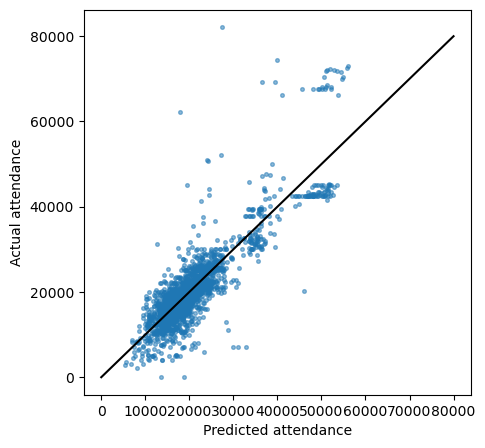

In [15]:
evaluate_linear_model(results, X, y)

The fit improved slightly. The R-squared is up to 0.739 and the RMSE is down to 4,885.

Playoff: I was surprised that the parameter for indicating whether a match was a playoff match was not significant at the 0.05 level.

Home openers: The parameter for home openers was significant and it indicates that home openers attract about 2,200 more people than would otherwise be expected.

Rivals: This parameter was also significant. Rivalry matches attract about 2,300 more people on average. Certain teams in MLS don't have rivalries, yet. Can we get Minnesota and Nashville to hate each other?

Real home team: Matches in which the home team was actually the home team averaged nearly 7,100 more fans.

The parameter for month is actually higher now (582).

Wednesdays and Thursdays are both statistically worse than Saturdays for attendance and the effect is quite large. Both get over 2000 fewer people per match.

None of the parameters for kick off time are significant still.

**Model 5**

This model will incorporate weather parameters

1. Whether it rained prior to match or at start of match.
2. Whether it snowed prior to match or at start of match.
3. Whether it was below 40 degrees Fahrenheit.
4. Whether it was above 90 degrees Fahrenheit.
5. Windspeed.

In [16]:
X = create_X(mlsall_df,
             columns=['home_team','away_team',
                      'day','date_month','local_time','date_year',
                      'playoff','home_opener','rivals','real_home_team',
                      'rain','snow','temperature','windspeed'],
             add_constant=True)
linreg = sm.OLS(y,X).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             attendance   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     77.02
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        13:29:23   Log-Likelihood:                -22057.
No. Observations:                2229   AIC:                         4.427e+04
Df Residuals:                    2149   BIC:                         4.473e+04
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
date_month       572.1905     56.687     10.094      0.000     461.023     683.358
playoff         1366.7481    740.555      1.846      0.065     -85.530    2819.026
home_opener     2358.1192    534.832      4.409      0.000    1309.276    3406.962
rivals          2266.5430    403.378      5.619      0.000    1475.490    3057.596
real_home_team  7104.7396   1282.425      5.540      0.000    4589.817    9619.662
windspeed         -4.5852     18.480     -0.248      0.804     -40.826      31.656
const           4.451e+04   1566.839     28.406      0.000    4.14e+04    4.76e+04
home_team_1    -2.813e+04    890.286    -31.601      0.000   -2.99e+04   -2.64e+04
home_team_2    -1.402e+04   1000.078    -14.017      0.000    -1.6e+04   -1.21e+04
home_team_3     -3.47e+04    758.330    -45.755      0.000   -3.62e+04   -3.32e+04
home_team_4     -2.52e+04    797.630    -31.592      0.000   -2.68e+04   -2.36e+04
home_team_5    -3.548e+04    770.376    -46.059      0.000    -3.7e+04    -3.4e+04
home_team_6    -3.303e+04    748.566    -44.120      0.000   -3.45e+04   -3.16e+04
home_team_7    -3.409e+04    762.619    -44.696      0.000   -3.56e+04   -3.26e+04
home_team_8    -3.324e+04    751.675    -44.224      0.000   -3.47e+04   -3.18e+04
home_team_9    -3.438e+04    767.359    -44.800      0.000   -3.59e+04   -3.29e+04
home_team_10   -2.756e+04    763.580    -36.098      0.000   -2.91e+04   -2.61e+04
home_team_11   -2.782e+04    754.325    -36.882      0.000   -2.93e+04   -2.63e+04
home_team_12   -2.993e+04    757.026    -39.534      0.000   -3.14e+04   -2.84e+04
home_team_13   -3.359e+04    884.490    -37.973      0.000   -3.53e+04   -3.19e+04
home_team_14   -3.366e+04    788.900    -42.672      0.000   -3.52e+04   -3.21e+04
home_team_15   -2.335e+04    863.579    -27.042      0.000    -2.5e+04   -2.17e+04
home_team_16   -2.972e+04    757.567    -39.233      0.000   -3.12e+04   -2.82e+04
home_team_17   -3.014e+04    760.180    -39.650      0.000   -3.16e+04   -2.87e+04
home_team_18   -3.264e+04    752.392    -43.382      0.000   -3.41e+04   -3.12e+04
home_team_19   -2.965e+04    747.123    -39.687      0.000   -3.11e+04   -2.82e+04
home_team_20   -3.258e+04    734.023    -44.389      0.000    -3.4e+04   -3.11e+04
home_team_21   -2.726e+04    762.610    -35.748      0.000   -2.88e+04   -2.58e+04
home_team_22    -3.14e+04    769.898    -40.787      0.000   -3.29e+04   -2.99e+04
home_team_23   -3.304e+04    775.435    -42.602      0.000   -3.46e+04   -3.15e+04
home_team_24    -1.51e+04    760.473    -19.862      0.000   -1.66e+04   -1.36e+04
home_team_25   -3.076e+04    756.851    -40.637      0.000   -3.22e+04   -2.93e+04
home_team_26   -2.841e+04   1327.989    -21.393      0.000    -3.1e+04   -2.58e+04
home_team_27   -2.699e+04    760.123    -35.507      0.000   -2.85e+04   -2.55e+04
home_team_28

RMSE of residuals: 4888.42769570239
68.3% interval: -3335.80776962071 3070.165590879606
Width of 68.3% interval: 6405.973360500317
R-squared: 0.7390052731571286


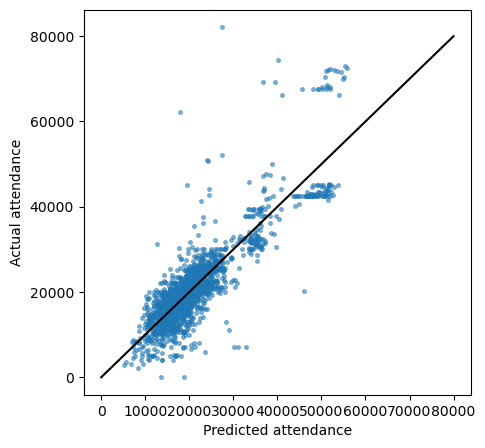

In [17]:
evaluate_linear_model(results, X, y)

There was no improvement to the fit and no indication that any of the weather parameters had an effect on the attendance. Weather parameters will not be included in the fit for subsequent models.

**Model 6**

For this model, I am going to remove parameters that were not significant. This means I will remove the following:

1. All weather parameters.
2. Kick off time parameters.

In [55]:
X = create_X(mlsall_df,
             columns=['home_team','away_team',
                      'day','date_month','date_year',
                      'playoff','home_opener','rivals','real_home_team'],
             add_constant=True)
linreg = sm.OLS(y,X).fit()
linreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             attendance   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     85.76
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:44:40   Log-Likelihood:                -22059.
No. Observations:                2229   AIC:                         4.426e+04
Df Residuals:                    2157   BIC:                         4.467e+04
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
date_month       585.3170     54.818     10.678      0.000     477.816     692.818
playoff         1234.8856    726.559      1.700      0.089    -189.944    2659.715
home_opener     2245.9457    501.684      4.477      0.000    1262.111    3229.781
rivals          2228.4335    401.071      5.556      0.000    1441.908    3014.959
real_home_team  7246.4885   1269.919      5.706      0.000    4756.096    9736.881
const           4.472e+04   1507.731     29.661      0.000    4.18e+04    4.77e+04
home_team_1    -2.834e+04    867.581    -32.661      0.000      -3e+04   -2.66e+04
home_team_2    -1.414e+04    995.497    -14.202      0.000   -1.61e+04   -1.22e+04
home_team_3     -3.49e+04    742.341    -47.013      0.000   -3.64e+04   -3.34e+04
home_team_4    -2.529e+04    791.608    -31.949      0.000   -2.68e+04   -2.37e+04
home_team_5    -3.557e+04    760.867    -46.748      0.000   -3.71e+04   -3.41e+04
home_team_6    -3.313e+04    740.888    -44.720      0.000   -3.46e+04   -3.17e+04
home_team_7    -3.421e+04    750.723    -45.566      0.000   -3.57e+04   -3.27e+04
home_team_8    -3.341e+04    739.082    -45.201      0.000   -3.49e+04    -3.2e+04
home_team_9    -3.451e+04    755.813    -45.666      0.000    -3.6e+04    -3.3e+04
home_team_10    -2.76e+04    754.017    -36.597      0.000   -2.91e+04   -2.61e+04
home_team_11   -2.787e+04    743.997    -37.456      0.000   -2.93e+04   -2.64e+04
home_team_12   -3.004e+04    749.272    -40.098      0.000   -3.15e+04   -2.86e+04
home_team_13   -3.377e+04    870.886    -38.780      0.000   -3.55e+04   -3.21e+04
home_team_14   -3.379e+04    781.827    -43.215      0.000   -3.53e+04   -3.23e+04
home_team_15   -2.345e+04    858.346    -27.314      0.000   -2.51e+04   -2.18e+04
home_team_16   -2.987e+04    748.587    -39.908      0.000   -3.13e+04   -2.84e+04
home_team_17   -3.027e+04    754.456    -40.121      0.000   -3.17e+04   -2.88e+04
home_team_18   -3.273e+04    745.428    -43.902      0.000   -3.42e+04   -3.13e+04
home_team_19   -2.974e+04    743.239    -40.020      0.000   -3.12e+04   -2.83e+04
home_team_20   -3.266e+04    727.529    -44.892      0.000   -3.41e+04   -3.12e+04
home_team_21   -2.737e+04    753.582    -36.322      0.000   -2.88e+04   -2.59e+04
home_team_22   -3.158e+04    750.741    -42.059      0.000    -3.3e+04   -3.01e+04
home_team_23   -3.306e+04    765.012    -43.211      0.000   -3.46e+04   -3.16e+04
home_team_24   -1.526e+04    746.269    -20.450      0.000   -1.67e+04   -1.38e+04
home_team_25   -3.085e+04    749.296    -41.177      0.000   -3.23e+04   -2.94e+04
home_team_26   -2.863e+04   1318.979    -21.708      0.000   -3.12e+04    -2.6e+04
home_team_27   -2.709e+04    751.436    -36.056      0.000   -2.86e+04   -2.56e+04
home_team_28   -3.243e+04    772.756    -41.961      0.000   -3.39e+04   -3.09e+04
away_team_1 

RMSE of residuals: 4884.843861590792
68.3% interval: -3310.00018724624 3088.602211163237
Width of 68.3% interval: 6398.602398409477
R-squared: 0.7384176459978459


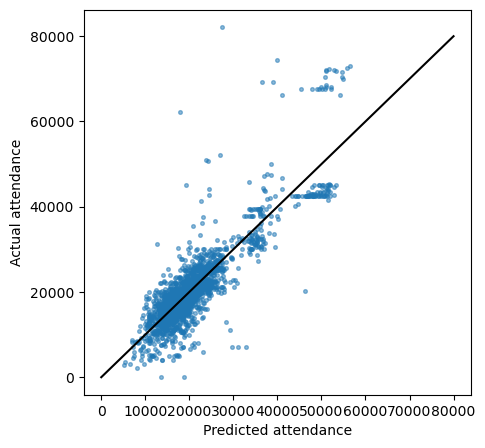

In [56]:
evaluate_linear_model(linreg, X, y)

This model has an R-squared of 0.738 and the RMSE is 4,885.

This is the best performing linear model. Below, I dig into the results a little more to see how well the model performed.

First, I am going to be using a train-test split for the other types of models I will try. In order to make a more direct comparison to those models, I would like to evaluate the linear regression model on those splits.

In [62]:
# Set random seed that will be used for ALL train-test splits
rando = 42

In [63]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rando, test_size=0.2)

RMSE:
Train: 4949.2
Test: 4176.2

R-squared:
Train: 0.74
Test: 0.731

Width of 68.3% interval
Train: 6388.7
Test: 6396.1


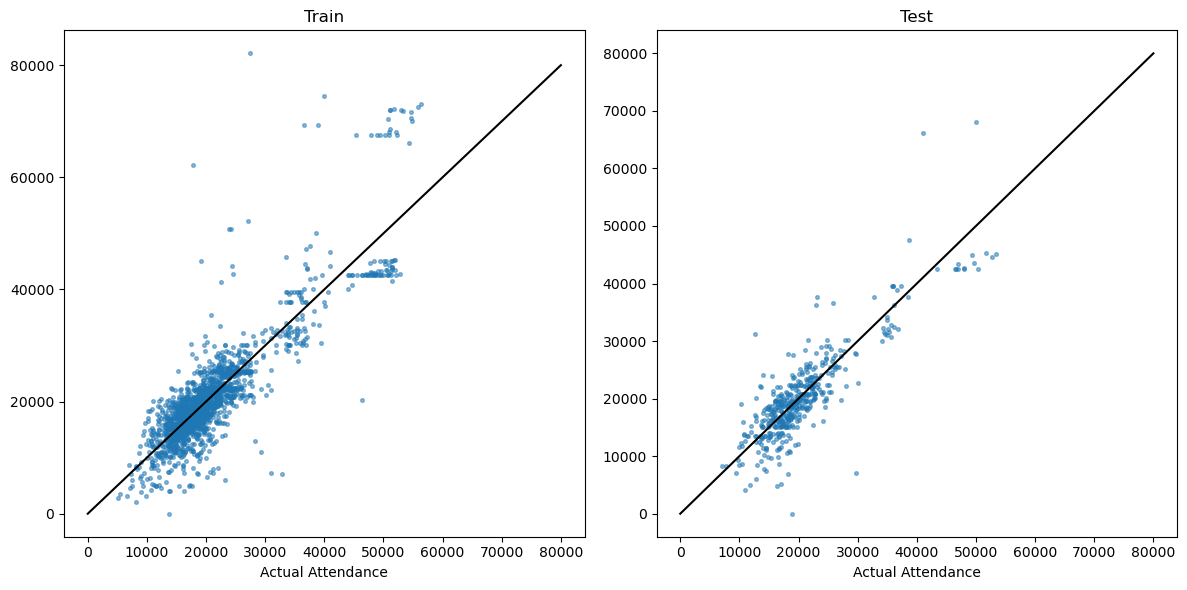

In [65]:
evaluate_model_split(linreg, X_train, y_train, X_test, y_test)

Despite fitting all of the data without the split, there does not appear to be an issue with overfitting. This is not surprising as a linear regression model is likely too simple to overfit the data.

For the other types of models, the benchmark performance for the test data is the following:

RMSE = 4,176.2

R-squared = 0.731

Width of 68.3% interval = 6396.1

I want to look at how the fit performed on a team-by-team basis. The dictionary below turns the IDs in home_team and away_team into the actual team names.

In [20]:
team_names = {0: 'Atlanta United',
              1: 'Austin FC',
              2: 'Charlotte FC',
              3: 'Chicago Fire',
              4: 'FC Cincinnati',
              5: 'Colorado Rapids',
              6: 'Columbus Crew',
              7: 'FC Dallas',
              8: 'D.C. United',
              9: 'Houston Dynamo',
              10: 'Los Angeles Galaxy',
              11: 'Los Angeles FC',
              12: 'Minnesota United',
              13: 'Inter Miami',
              14: 'CF Montreal',
              15: 'Nashville SC',
              16: 'New England Revolution',
              17: 'New York City FC',
              18: 'New York Red Bulls',
              19: 'Orlando City',
              20: 'Philadelphia Union',
              21: 'Portland Timbers',
              22: 'Real Salt Lake',
              23: 'San Jose Earthquakes',
              24: 'Seattle Sounders',
              25: 'Sporting Kansas City',
              26: 'St. Louis FC',
              27: 'Toronto FC',
              28: 'Vancouver Whitecaps'}

In [25]:
# Get predictions from the model
y_pred_lr = linreg.predict(X)
y_pred_lr

0       26351.649523
1       17357.459412
2       38013.993525
3       18300.935142
4       18820.764985
            ...     
2278    25008.744362
2279    22758.300279
2280    19966.712857
2281    24946.653567
2282    21728.253508
Length: 2229, dtype: float64

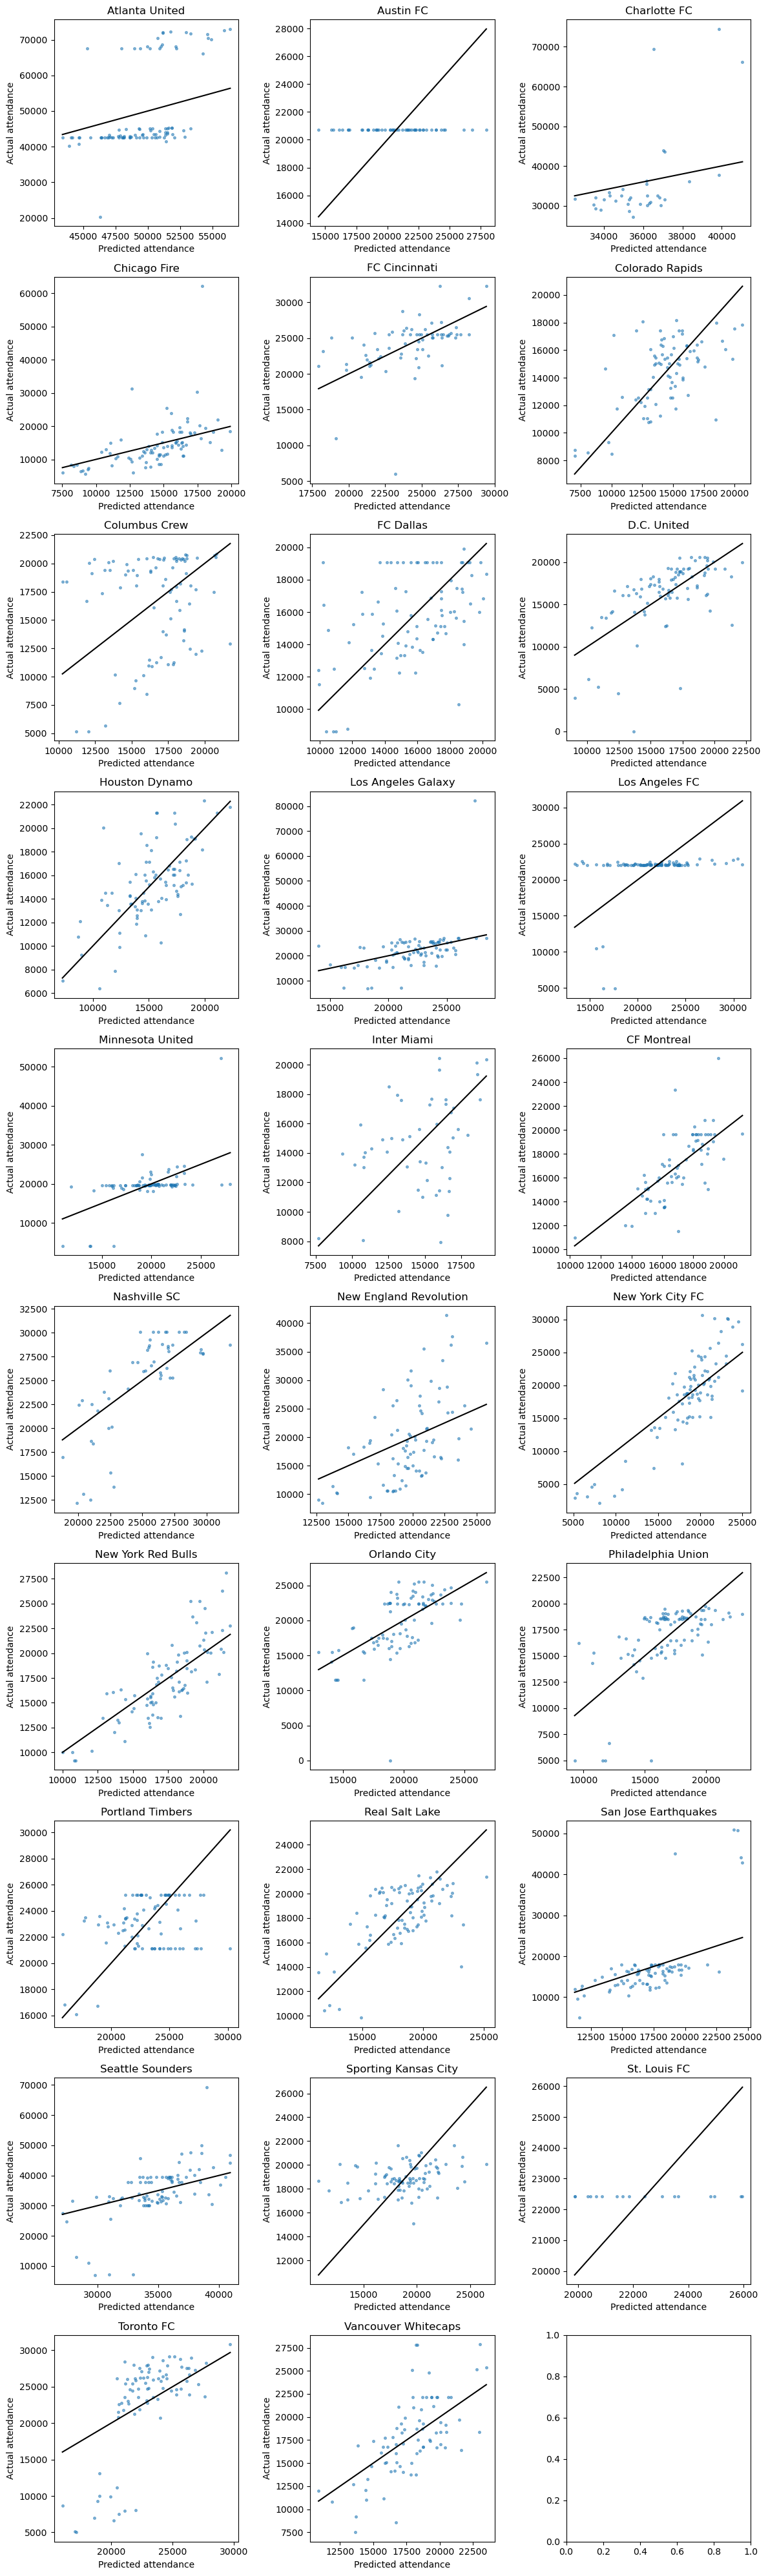

In [26]:
# Plot actual attendance vs. predicted attendance for each team's home matches
fig, ax = plt.subplots(ncols=3, nrows=10, figsize=(12,40))

for ht in range(29):
    r = ht//3
    c = ht%3
    
    y_pred_ht = y_pred_lr[mlsall_df['home_team']==ht]
    
    ax[r,c].scatter(y_pred_ht,
                    y[mlsall_df['home_team']==ht],
                    s=7,
                    alpha=0.5)
    
    ax[r,c].set_title(team_names[ht])
    ax[r,c].set_xlabel('Predicted attendance')
    ax[r,c].set_ylabel('Actual attendance')
    
    ax[r,c].plot([np.min(y_pred_ht),np.max(y_pred_ht)],
                 [np.min(y_pred_ht),np.max(y_pred_ht)],
                 color='black')
    
fig.tight_layout()

The predictions are quite solid for some teams, but not for others.

The model struggles the most with teams that change the capacity of their stadiums. Atlanta United is a good example. Usually, they use a capacity around 45,000, but then expand it to over 70,000 for other matches. The changing capacity means that the model struggles to fit the data which is grouped into two parts of the graph. In the case of Atlanta, I can tell pretty clearly what capacity was being used in a given match, but that is not the case for all teams.

The artifically reduced capacity of Gillette Stadium, used by the New England Revolution, is listed as 20,000, but many of their matches have a higher attendance than that. In contrast to teams like Atlanta United, there seems to be a continuum of values above 20,000 rather than one unique, higher capacity. This implies that New England uses a less rigid capacity for its home matches, making it impossible to tell what capacity they used, if they used one at all.

The model also struggled with teams that had very consistent home attendance. The most obvious cases are Austin FC and St. Louis FC who have had the same (or nearly the same attendance) for every home match they have played. The model expects the attendance to vary from match to match depending on changes in the parameters, but there just isn't any variance for these teams. Similar issues are present for these teams that just have less variance in attendance: Los Angeles FC, Minnesota United, and Sporting Kansas City.

These teams outline a second problem with the model which is that there is a true maximum capacity for each stadium that cannot be exceeded, but the linear model does not incorporate that limit. Austin FC cannot have more than 20,738 people in Q2 Stadium, but the model still predicts values greater than that value.

One metric for judging how well the model fits each team is the RMSE. Below, I plot the RMSE for each teams' home matches.

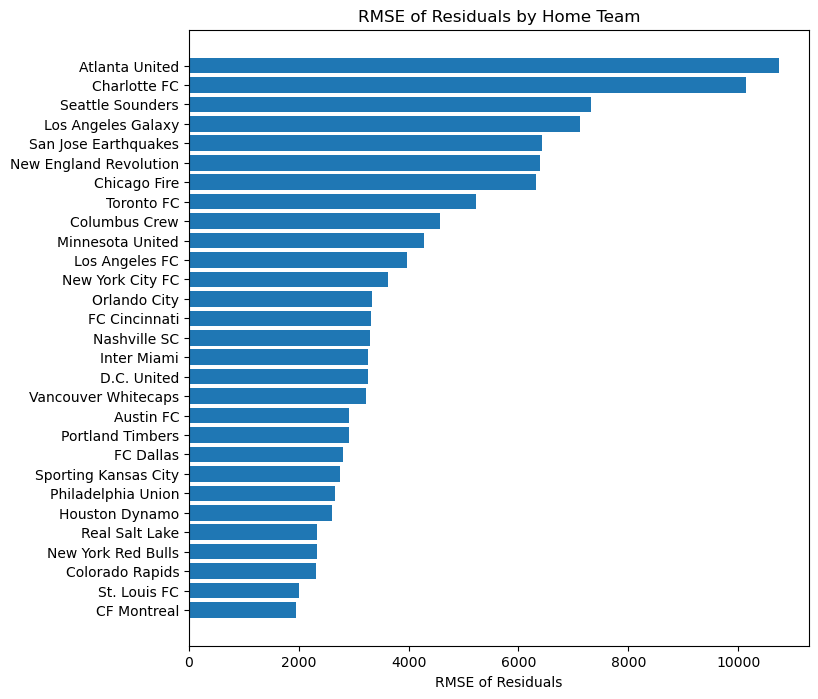

In [27]:
# RMSE of residuals for each home team
fig, ax = plt.subplots(figsize=(8,8))

rmse_team = []
for ht in range(29):
    rmse_team.append(np.sqrt(np.var(linreg.resid[mlsall_df['home_team']==ht])))
    
ax.barh(y=np.arange(29), width=np.sort(rmse_team))

ax.set_yticks(np.arange(29))
ax.set_yticklabels([team_names[x] for x in np.argsort(rmse_team)])
ax.set_xlabel('RMSE of Residuals')
ax.set_title('RMSE of Residuals by Home Team');

Unsurprisingly, the highest RMSE values are for the 3 teams that often change their stadium capacity (Atlanta, Charlotte, and Seattle). For 19 of the 29 teams, the RMSE is below 4,000.

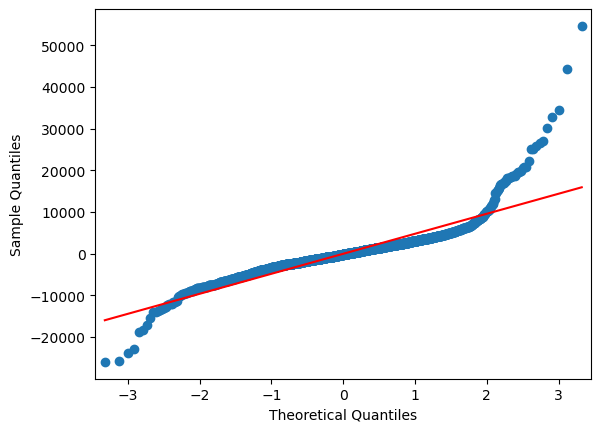

In [28]:
# Make Quantile-Quantile plot to compare to normal distribution
sm.qqplot(results.resid,line='s');

The Q-Q plot above shows that the distribution of residuals is close to normal except at the edges.

Text(0, 0.5, 'Residuals')

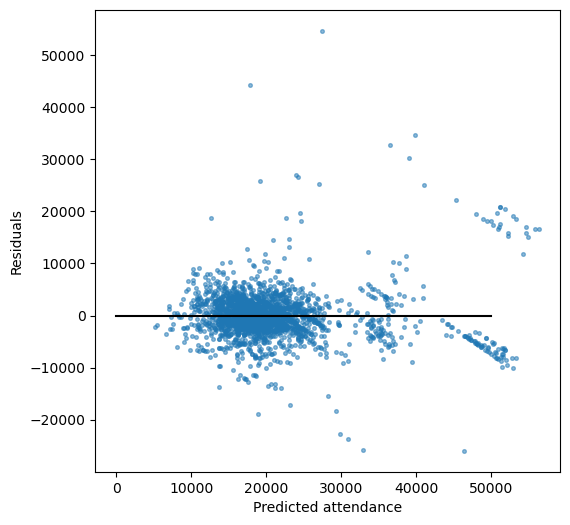

In [29]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(linreg.predict(sm.add_constant(X)),
           linreg.resid,
           alpha=0.5,
           s=7)

ax.plot([0,50000],[0,0],color='black')

ax.set_xlabel('Predicted attendance')
ax.set_ylabel('Residuals')

In [42]:
mlsall_df['prediction'] = results.predict(X)

In [52]:
mlsall_df[(mlsall_df['away_team']==12)&(mlsall_df['date_year']==2023)][['date',
                                                                           'home_team',
                                                                           'away_team',
                                                                           'attendance',
                                                                           'prediction',
                                                                           'stadium',
                                                                           'real_home_team',
                                                                           'temperature',
                                                                           'rain_sum']]

,date,home_team,away_team,attendance,prediction,stadium,real_home_team,temperature,rain_sum
1792,2023-02-25,7,12,19096,15240.808118,Toyota Stadium,1,42.8,4.6
1841,2023-03-18,5,12,12538,12875.296565,Dick's Sporting Goods Park,1,38.8,0.0
1871,2023-04-01,26,12,22423,21381.450343,Citypark,1,52.0,4.3
1885,2023-04-08,3,12,12128,13660.161334,Soldier Field,1,53.6,0.0
1914,2023-04-22,24,12,30025,33547.774541,Lumen Field,1,51.1,0.1
1940,2023-05-06,28,12,14047,16981.844379,BC Place Stadium,1,51.8,2.6
1952,2023-05-13,25,12,17851,18170.205419,Children's Mercy Park,1,80.4,0.0
1978,2023-05-20,21,12,22137,21983.281472,Providence Park,1,73.0,0.0
2003,2023-05-31,1,12,20738,16919.479740,Q2 Stadium,1,84.6,0.0
2025,2023-06-10,14,12,17030,16495.927779,Stade Saputo,1,70.0,0.1


(array([  2.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   1.,   3.,   1.,   4.,   4.,   4.,   1.,   3.,   6.,   6.,
          7.,  11.,   5.,  13.,  32.,  43.,  48.,  78.,  80., 106., 121.,
        185., 264., 250., 262., 187., 156., 117.,  79.,  35.,  21.,  16.,
         13.,   3.,   5.,   8.,   3.,   3.,   1.,   0.,   4.,   1.,   3.,
          8.,   3.,   2.,   4.,   2.,   2.,   0.,   0.,   0.,   0.,   1.,
          4.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-31013.62786201, -30133.97458651, -29254.32131102, -28374.66803552,
        -27495.01476002, -26615.36148452, -25735.70820902, -24856.05493352,
        -23976.40165802, -23096.74838252, -22217.09510702, -21337.44183153,
        -20457.78855603, -19578.13528053, -18698.48200503, -17818.82872953,
        -16939

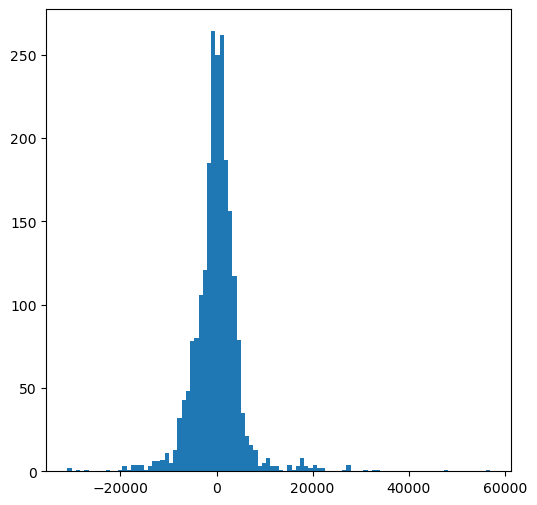

In [56]:
fig, ax = plt.subplots(figsize=(6,6))

ax.hist(results.resid, bins=100)

In [45]:
X

,date_month,playoff,home_opener,rivals,real_home_team,const,home_team_1,home_team_2,home_team_3,home_team_4,...,day_Fri,day_Mon,day_Sun,day_Thu,day_Tue,day_Wed,date_year_2019,date_year_2021,date_year_2022,date_year_2023
0,-4,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-4,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-4,0,1,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,-4,0,1,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,-4,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278,3,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2279,3,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2280,3,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2281,3,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### XGBoost Regression

Next, I use an extreme gradient boosting regression model, XGBRegressor.

In [41]:
def evaluate_model_split(model, X_train, y_train, X_test, y_test):
    """
    This function makes plots of actual attendance vs. predicted attendance
    for both train and test datasets. It also calculates the following for
    each dataset:
    RMSE of residuals
    R-squared of fit
    Width of 68.3% interval of residuals
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print("RMSE:")
    print(f"Train: {np.round(np.std(y_train-y_train_pred),1)}")
    print(f"Test: {np.round(np.std(y_test-y_test_pred),1)}")
    print()
    print("R-squared:")
    print(f"Train: {np.round(1.0 - np.var(y_train-y_train_pred)/np.var(y_train),3)}")
    print(f"Test: {np.round(1.0 - np.var(y_test-y_test_pred)/np.var(y_test),3)}")
    print()
    print("Width of 68.3% interval")
    print(f"Train: {np.round(np.quantile(y_train-y_train_pred,0.8415)-np.quantile(y_train-y_train_pred,0.1585),1)}")
    print(f"Test: {np.round(np.quantile(y_test-y_test_pred,0.8415)-np.quantile(y_test-y_test_pred,0.1585),1)}")
    
    fig, ax = plt.subplots(ncols=2, figsize=(12,6))
    
    # Train
    ax[0].scatter(y_train_pred,
                  y_train,
                  s=7,
                  alpha=0.5)
    # Plot x=y line
    ax[0].plot([0,80000],[0,80000], color='black')
    ax[0].set_xlabel('Predicted Attendance')
    ax[0].set_xlabel('Actual Attendance')
    ax[0].set_title('Train')
    
    # Test
    ax[1].scatter(y_test_pred,
                  y_test,
                  s=7,
                  alpha=0.5)
    # Plot x=y line
    ax[1].plot([0,80000],[0,80000], color='black')
    ax[1].set_xlabel('Predicted Attendance')
    ax[1].set_xlabel('Actual Attendance')
    ax[1].set_title('Test')
    
    fig.tight_layout()

In [30]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from model_funcs import *

**Model 1**

First, I want to see how well XGBRegressor performs with the default hyperparameters.

I am going to include all of the possible columns in my input data.

In [164]:
# Create input DataFrame, X
X = create_X(mlsall_df, columns=['home_team','away_team',
                                 'day','date_month','date_year','local_time',
                                 'playoff','home_opener','rivals','real_home_team',
                                 'temperature','rain','snow','windspeed'])
# Apply the same train-test split that was used earlier
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rando, test_size=0.2)

In [165]:
# Instantiate XGBClassifier
xgb = XGBRegressor()

# Fit model
xgb.fit(X_train, y_train)

RMSE:
Train: 3966.7
Test: 4847.2

R-squared:
Train: 0.833
Test: 0.638

Width of 68.3% interval
Train: 2097.3
Test: 5700.0


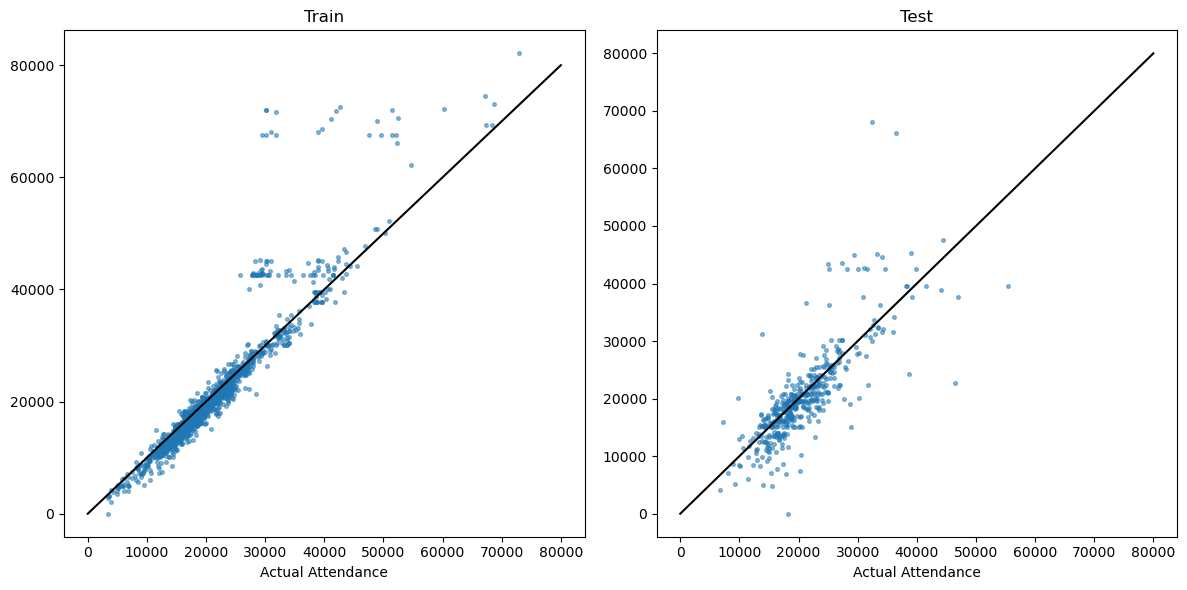

In [166]:
# Evaluate XGBRegressor model 1
evaluate_model_split(xgb, X_train, y_train, X_test, y_test)

The model is overfitting a bit as the R-squared value is 0.833 for the train dataset, but just 0.638 for the test dataset. The RMSE is also higher for the test data. Some hyperparameters will need to be adjusted to improve the fit.

Both the RMSE and R-squared values are worse for the test data than they were for the linear regression model. Below, I start searching for the combinations of hyperparameters that will improve the model.

In [221]:
def xgb_gridsearch(param_grid, X_train, y_train, X_test, y_test):
    """
    This function finds the best combination of hyperparameters for the XGBRegressor
    by training with one dataset, then evaluating using another.
    
    The function evaluates the fit using the R-squared metric, which is the default
    for the XGBRegressor.
    
    Inputs:
    param_grid: Grid of hyperparameters for the XGBRegressor.
    X_train, y_train: Training data
    X_test, y_test: Test data
    
    Outputs:
    xgb_best: Model that achieves the best performance on the test data.
    best_params: Dictionary of the best hyperparameters.
    param_indices: Numpy array of indices for each combination of hyperparameters.
    all_scores: Numpy array of all the train and test scores (R-squared values).
    """
    # Length for each hyperparameter list
    grid_lens = [len(param_grid[key]) for key in param_grid.keys()]
    grid_prods = np.cumprod([1]+grid_lens)
    
    # Initialize the best R-squared to be as bad as possible
    best_score = -1.0
    
    # Best parameters
    best_params = []
    
    # List of all the scores
    all_scores = []
    
    # Parameter indices per model
    param_indices = []
    
    for number in range(grid_prods[-1]):
        # Get the indices for the next combination of parameters
        indices = [(number//grid_prods[x])%grid_lens[x] for x in range(len(grid_lens))]
        
        param_indices.append(indices)
        
        # Make parameter dictionary
        param_dict = {key: param_grid[key][indices[i]] for i,key in enumerate(param_grid.keys())}
        
        # Make new instance of XGBRegressor
        xgb = XGBRegressor(**param_dict)
        
        # Fit to train data
        xgb.fit(X_train, y_train)
        
        # Get test score
        train_score = xgb.score(X_train, y_train)
        test_score = xgb.score(X_test, y_test)
        all_scores.append([train_score, test_score])
        
        # Save if the best model so far
        if test_score > best_score:
            best_score = test_score
            xgb_best = xgb
            best_params = param_dict
            
    
            
    return xgb_best, best_params, np.array(param_indices), np.array(all_scores)

**Model 2**

Below, I use a custom function, xgb_gridsearch, which can be found in model_funcs.py. First, I just want to try out different tree depths and number of estimators.

In [234]:
# Create parameter grid
param_grid_xgb = {
    'max_depth': [3,4,5,6,7,8,9,None],
    'n_estimators': [50,100,200,250,300,350,400],
    'booster': ['gbtree']
}

# Search for optimal parameter combination
xgb_best, best_params, params, scores = xgb_gridsearch(param_grid_xgb, X_train, y_train, X_test, y_test)

In [235]:
best_params

{'max_depth': 4, 'n_estimators': 400, 'booster': 'gbtree'}

RMSE:
Train: 2983.8
Test: 4052.0

R-squared:
Train: 0.905
Test: 0.747

Width of 68.3% interval
Train: 1850.0
Test: 5373.9


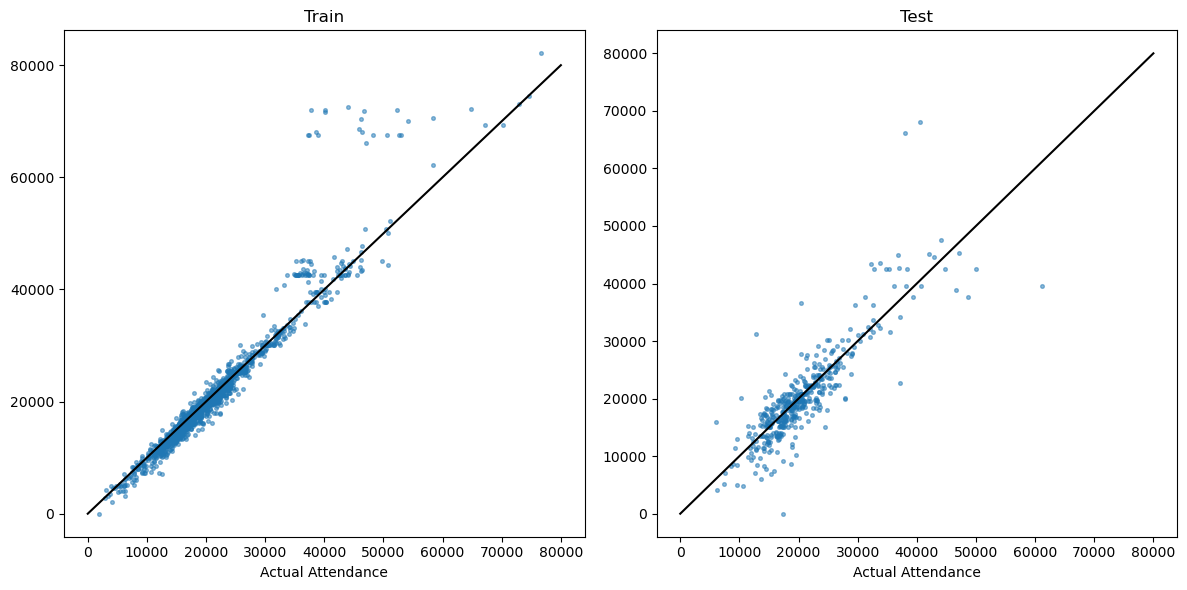

In [236]:
# Evaluate XGBRegressor model
evaluate_model_split(xgb_best, X_train, y_train, X_test, y_test)

The best model had a max_depth of 4 and 400 estimators.

The performance is already slightly better than the linear regression model. The RMSE of the residuals was 4,052 for the test data and the R-squared is 0.747, which is slightly higher than the 4,176 and 0.731 that the linear regression model achieved.

The model did overfit as the metrics for the training data was significantly better than the test data. Some regularization might come in handy.

**Model 3**

Next, I introduce learning_rate, reg_lambda, and subsample to the parameter grid. The hope is that reg_lambda and subsample will help with the overfitting.

In [241]:
# Create parameter grid
param_grid_xgb = {
    'max_depth': [3,4,5,6],
    'n_estimators': [350,400,450],
    'booster': ['gbtree'],
    'learning_rate':[0.3,0.4,0.5,0.6],
    'reg_alpha':[0.1,1,10],
    'subsample':[0.6,0.7,0.8,0.9,1]
}

# Search for optimal parameter combination
xgb_best, best_params, params, scores = xgb_gridsearch(param_grid_xgb, X_train, y_train, X_test, y_test)

In [242]:
best_params

{'max_depth': 3,
 'n_estimators': 450,
 'booster': 'gbtree',
 'learning_rate': 0.4,
 'reg_alpha': 10,
 'subsample': 1}

RMSE:
Train: 3091.7
Test: 3790.5

R-squared:
Train: 0.898
Test: 0.778

Width of 68.3% interval
Train: 2532.4
Test: 5147.9


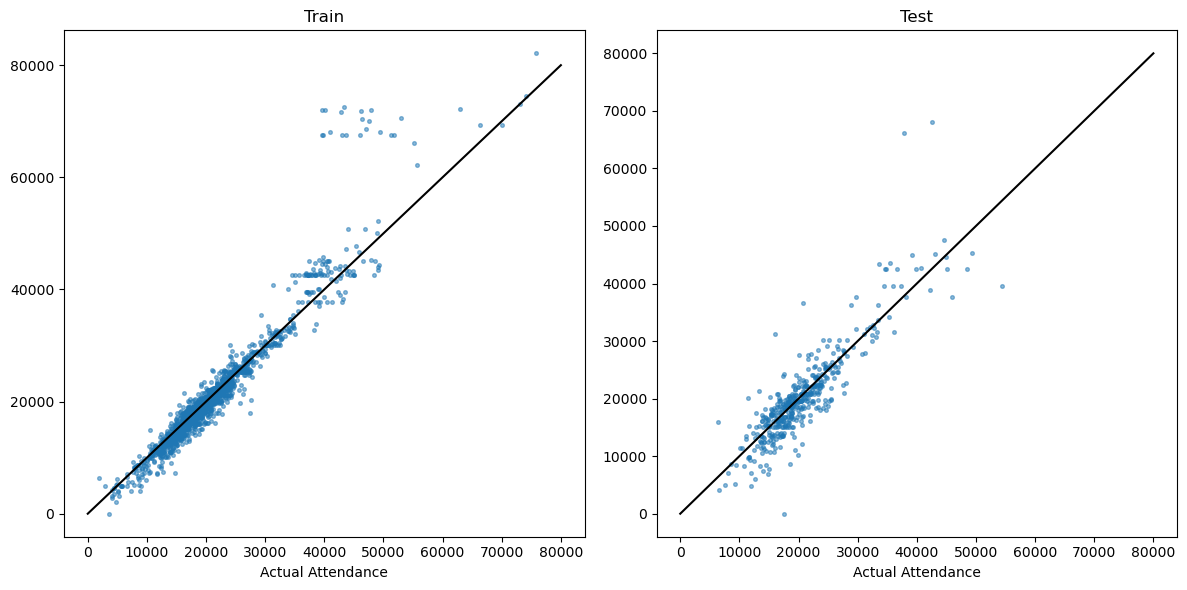

In [243]:
# Evaluate XGBRegressor model
evaluate_model_split(xgb_best, X_train, y_train, X_test, y_test)

The fit once again improved a bit. The new RMSE and R-squared values are 3790.5 and 0.778.

The best parameter values were:

1. max_depth = 3
2. n_estimators = 450
3. learning_rate = 0.4
4. reg_alpha = 10
5. subsample = 1

The overfitting is still present.

**Number of estimators**

So far, every time I have run a grid search, the largest number of estimators has always been chosen for the best performing model. Below, I look at the performance of the models varying only the number of estimators, keeping all other parameters equal to their optimal values in the last model.

In [247]:
# Create parameter grid
param_grid_xgb = {
    'max_depth': [3],
    'n_estimators': [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000],
    'booster': ['gbtree'],
    'learning_rate':[0.4],
    'reg_alpha':[10],
    'subsample':[1]
}

# Search for optimal parameter combination
xgb_best, best_params, params, scores = xgb_gridsearch(param_grid_xgb, X_train, y_train, X_test, y_test)

In [248]:
best_params

{'max_depth': 3,
 'n_estimators': 850,
 'booster': 'gbtree',
 'learning_rate': 0.4,
 'reg_alpha': 10,
 'subsample': 1}

In [258]:
scores

array([[0.58176354, 0.56115607],
       [0.68473997, 0.6407979 ],
       [0.7456732 , 0.68582108],
       [0.7891825 , 0.7161815 ],
       [0.82193782, 0.73940549],
       [0.84872748, 0.755196  ],
       [0.86837115, 0.76605971],
       [0.88547311, 0.77104763],
       [0.89840602, 0.77741763],
       [0.90818945, 0.77982765],
       [0.91697631, 0.78441863],
       [0.9272345 , 0.78883802],
       [0.93259602, 0.79025905],
       [0.93758053, 0.79380286],
       [0.94162252, 0.7963117 ],
       [0.94625203, 0.7962279 ],
       [0.95128607, 0.79695159],
       [0.955332  , 0.79605779],
       [0.95976244, 0.7961276 ],
       [0.96376519, 0.79343146]])

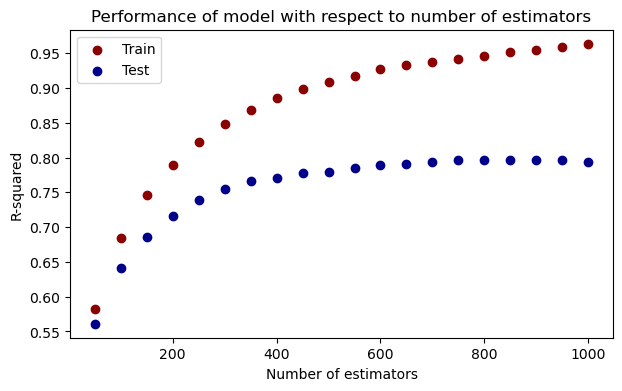

In [257]:
fig, ax = plt.subplots(figsize=(7,4))

ax.scatter(param_grid_xgb['n_estimators'],scores[:,0],label='Train', color='darkred')
ax.scatter(param_grid_xgb['n_estimators'],scores[:,1],label='Test',color='darkblue')
ax.set_xlabel('Number of estimators')
ax.set_ylabel('R-squared')
ax.set_title('Performance of model with respect to number of estimators')

ax.legend()

As the number of estimators increases, the fit on the training data continues to improve as the model overfits more. Despite the overfitting, the performance on the test dataset also continues to improve until it levels out. The R-squared value almost reaches 0.8 (maxes out at 0.797), but reaches 0.784 with just 450 estimators.

RMSE:
Train: 2140.9
Test: 3623.5

R-squared:
Train: 0.951
Test: 0.797

Width of 68.3% interval
Train: 1852.5
Test: 5299.1


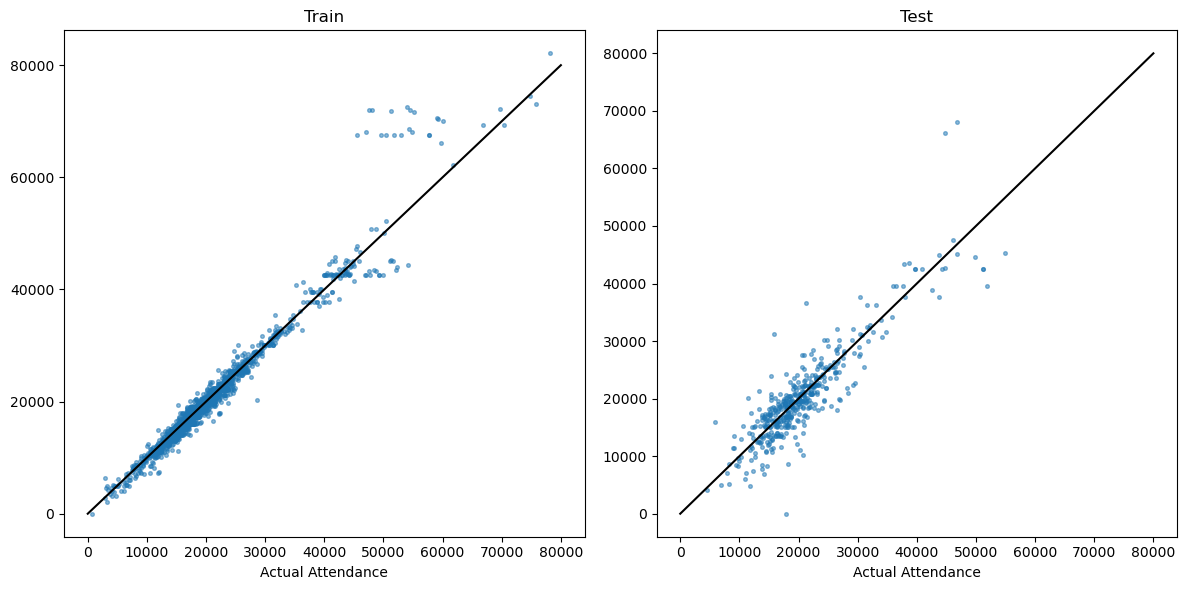

In [250]:
# Evaluate XGBRegressor model
evaluate_model_split(xgb_best, X_train, y_train, X_test, y_test)

In [230]:
param_grid_xgb = {
    'learning_rate': [0.3,0.4,0.5,0.6,0.7],
    'max_depth': [3,4,5,6],
    #'min_child_weight': [1,2,3],
    #'subsample': [0.5, 0.7, 0.9],
    'n_estimators': [250,300,350,400],
    'booster': ['gbtree'],
    'reg_lambda':[0.1,1,10]
}

xgb_best, best_params, params, scores = xgb_gridsearch(param_grid_xgb, X_train, y_train, X_test, y_test)

In [231]:
best_params

{'learning_rate': 0.5,
 'max_depth': 3,
 'n_estimators': 400,
 'booster': 'gbtree',
 'reg_lambda': 0.1}

In [232]:
scores

array([[0.78665553, 0.68069101],
       [0.83316227, 0.7171828 ],
       [0.868164  , 0.76759304],
       [0.89649707, 0.71061459],
       [0.91458542, 0.72392588],
       [0.86783058, 0.69317897],
       [0.90888539, 0.67327708],
       [0.92954454, 0.71624032],
       [0.95289343, 0.68463929],
       [0.97610248, 0.69958457],
       [0.90915808, 0.71466395],
       [0.96232908, 0.64444697],
       [0.96796421, 0.71571932],
       [0.98473106, 0.73573978],
       [0.99631197, 0.63653401],
       [0.93979453, 0.70015307],
       [0.98775374, 0.68665243],
       [0.99309568, 0.64023756],
       [0.99940639, 0.52672369],
       [0.9997911 , 0.55856467],
       [0.81210353, 0.70018334],
       [0.85708826, 0.73208312],
       [0.89092333, 0.77605389],
       [0.91527575, 0.71368028],
       [0.9396658 , 0.72208673],
       [0.88692913, 0.70845097],
       [0.92448387, 0.68104878],
       [0.95249697, 0.72859969],
       [0.96223444, 0.68675295],
       [0.99351121, 0.68709784],
       [0.

RMSE:
Train: 2710.5
Test: 3653.1

R-squared:
Train: 0.922
Test: 0.794

Width of 68.3% interval
Train: 2052.1
Test: 5194.7


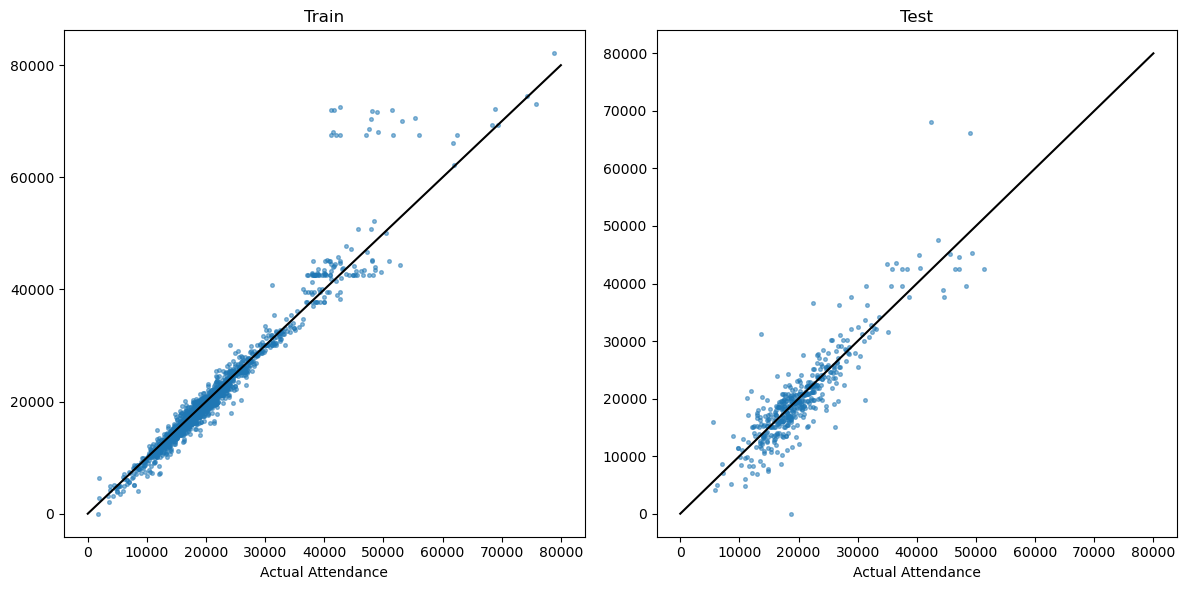

In [233]:
# Evaluate XGBRegressor model 1
evaluate_model_split(xgb_best, X_train, y_train, X_test, y_test)

In [222]:
# XGBRegression with GridSearchCV
xgb = XGBRegressor()

param_grid_xgb = {
    'learning_rate': [0.1,0.2,0.3,0.4,0.5],
    'max_depth': [3,4,5,6,7],
    #'min_child_weight': [1,2,3],
    #'subsample': [0.5, 0.7, 0.9],
    'n_estimators': [150,200,250,300],
    'booster': ['gbtree'],
    'reg_lambda':[0.1,1,10]
}

# Instantiate a GridSearchCV object
xgb_gridcv = GridSearchCV(xgb, param_grid=param_grid_xgb, cv=3, scoring='r2')

# Fit training data
xgb_gridcv.fit(X_train, y_train)

# Get best parameters
best_parameters = xgb_gridcv.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

# Get predictions for training and test data
y_train_pred = xgb_gridcv.predict(X_train)
y_test_pred = xgb_gridcv.predict(X_test)

Grid Search found the following optimal parameters: 
booster: 'gbtree'
learning_rate: 0.5
max_depth: 3
n_estimators: 300
reg_lambda: 10


In [223]:
xgb_gridcv.best_score_

0.5998827858654102

In [224]:
xgb_gridcv.score(X_test, y_test)

0.7545697500077172

RMSE:
Train: 3943.5
Test: 3981.4

R-squared:
Train: 0.835
Test: 0.755

Width of 68.3% interval
Train: 3687.1
Test: 5492.2


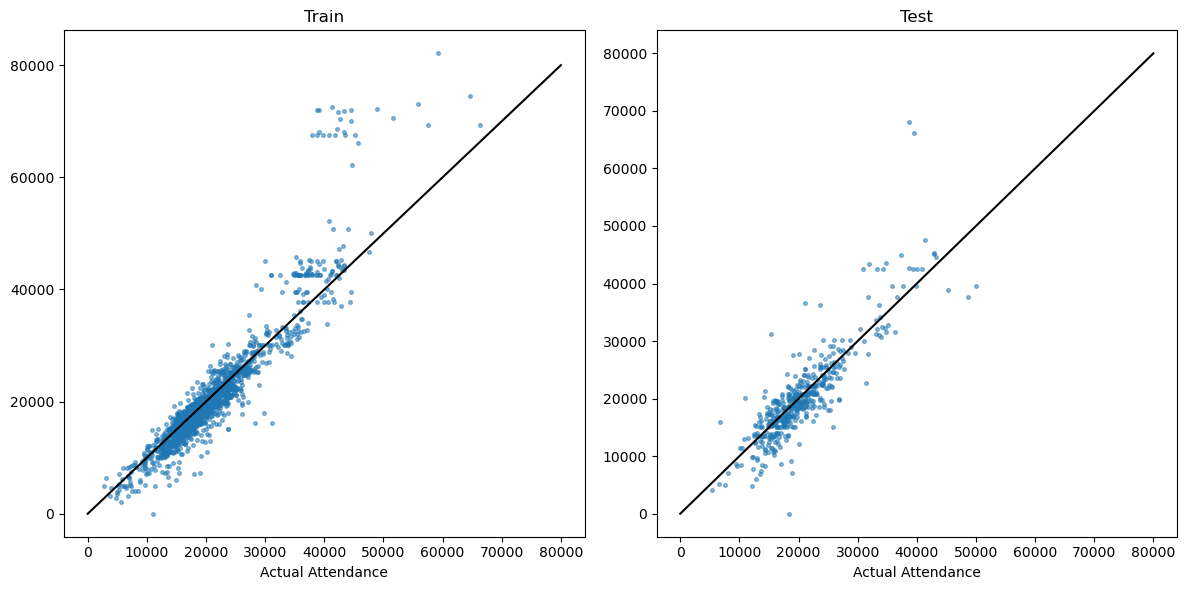

In [225]:
# Evaluate XGBRegressor model 1
evaluate_model_split(xgb_gridcv, X_train, y_train, X_test, y_test)

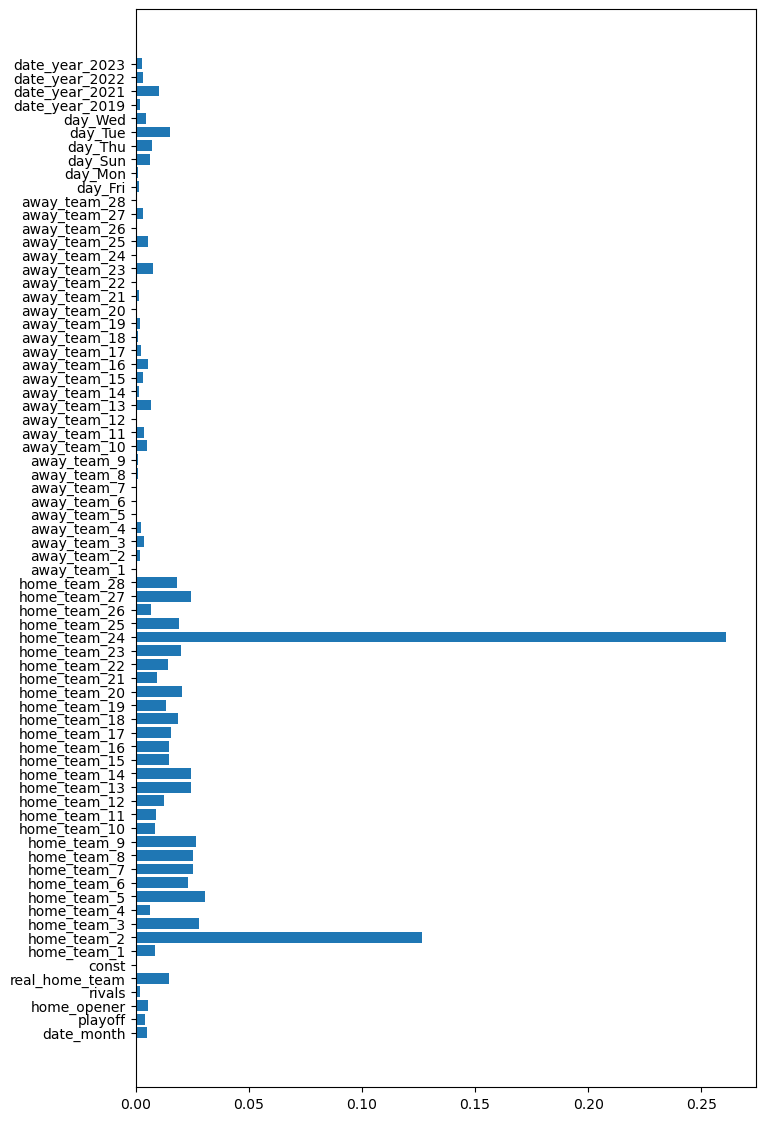

In [109]:
# Feature importance bar chart
fig, ax = plt.subplots(figsize=(8,14))
    
ax.barh(y=range(len(xgb.feature_importances_)), width=xgb.feature_importances_)

ax.set_yticks(range(len(xgb.feature_importances_)))
ax.set_yticklabels(xgb.feature_names_in_);

In [224]:
results = sm.OLS(y_train,X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             attendance   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     69.19
Date:                Thu, 02 Nov 2023   Prob (F-statistic):               0.00
Time:                        21:31:27   Log-Likelihood:                -17691.
No. Observations:                1783   AIC:                         3.553e+04
Df Residuals:                    1711   BIC:                         3.592e+04
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
date_month       603.5014     63.142      9.558      0.000     479.657     727.346
playoff         1193.1962    795.065      1.501      0.134    -366.205    2752.598
home_opener     2729.8819    571.283      4.779      0.000    1609.395    3850.369
rivals          2458.2266    460.676      5.336      0.000    1554.679    3361.774
real_home_team  9060.0151   1524.320      5.944      0.000    6070.288     1.2e+04
const           4.324e+04   1775.438     24.355      0.000    3.98e+04    4.67e+04
home_team_1    -2.904e+04   1001.770    -28.990      0.000    -3.1e+04   -2.71e+04
home_team_2    -1.523e+04   1141.588    -13.340      0.000   -1.75e+04    -1.3e+04
home_team_3    -3.583e+04    825.950    -43.377      0.000   -3.74e+04   -3.42e+04
home_team_4     -2.62e+04    882.982    -29.668      0.000   -2.79e+04   -2.45e+04
home_team_5    -3.624e+04    856.060    -42.339      0.000   -3.79e+04   -3.46e+04
home_team_6    -3.335e+04    831.066    -40.131      0.000    -3.5e+04   -3.17e+04
home_team_7      -3.5e+04    860.385    -40.683      0.000   -3.67e+04   -3.33e+04
home_team_8    -3.453e+04    850.531    -40.597      0.000   -3.62e+04   -3.29e+04
home_team_9    -3.536e+04    863.775    -40.941      0.000   -3.71e+04   -3.37e+04
home_team_10    -2.81e+04    848.005    -33.133      0.000   -2.98e+04   -2.64e+04
home_team_11   -2.866e+04    838.561    -34.179      0.000   -3.03e+04    -2.7e+04
home_team_12   -3.065e+04    859.499    -35.661      0.000   -3.23e+04    -2.9e+04
home_team_13   -3.441e+04    986.328    -34.890      0.000   -3.63e+04   -3.25e+04
home_team_14   -3.453e+04    908.721    -37.999      0.000   -3.63e+04   -3.27e+04
home_team_15   -2.411e+04   1038.993    -23.209      0.000   -2.62e+04   -2.21e+04
home_team_16   -3.073e+04    844.396    -36.398      0.000   -3.24e+04   -2.91e+04
home_team_17   -3.076e+04    858.889    -35.819      0.000   -3.24e+04   -2.91e+04
home_team_18   -3.337e+04    853.628    -39.094      0.000    -3.5e+04   -3.17e+04
home_team_19   -3.032e+04    869.283    -34.875      0.000    -3.2e+04   -2.86e+04
home_team_20   -3.324e+04    827.338    -40.178      0.000   -3.49e+04   -3.16e+04
home_team_21   -2.799e+04    863.305    -32.418      0.000   -2.97e+04   -2.63e+04
home_team_22    -3.24e+04    862.456    -37.562      0.000   -3.41e+04   -3.07e+04
home_team_23   -3.339e+04    857.001    -38.959      0.000   -3.51e+04   -3.17e+04
home_team_24   -1.577e+04    851.103    -18.533      0.000   -1.74e+04   -1.41e+04
home_team_25    -3.13e+04    854.361    -36.641      0.000    -3.3e+04   -2.96e+04
home_team_26   -2.932e+04   1455.886    -20.139      0.000   -3.22e+04   -2.65e+04
home_team_27   -2.839e+04    870.944    -32.600      0.000   -3.01e+04   -2.67e+04
home_team_28   -3.304e+04    904.937    -36.516      0.000   -3.48e+04   -3.13e+04
away_team_1 

In [236]:
print('TRAIN')
print(f"Variance of data: {np.sqrt(np.var(y_train))}")
print(f"RMSE of residuals: {np.sqrt(np.var(y_train-results.predict(X_train)))}")
print(f"68.3% interval: {np.quantile(y_train-results.predict(X_train), 0.1585)} {np.quantile(y_train-results.predict(X_train), 0.8415)}")
print(f"Width of 68.3% interval: {np.quantile(y_train-results.predict(X_train), 0.8415)-np.quantile(y_train-results.predict(X_train), 0.1585)}")
print(f"R-squared: {1.0 - np.var(y_train-results.predict(X_train))/np.var(y_train)}")
print()
print('TEST')
print(f"Variance of data: {np.sqrt(np.var(y_test))}")
print(f"RMSE of residuals: {np.sqrt(np.var(y_test-results.predict(X_test)))}")
print(f"68.3% interval: {np.quantile(y_test-results.predict(X_test), 0.1585)} {np.quantile(y_test-results.predict(X_test), 0.8415)}")
print(f"Width of 68.3% interval: {np.quantile(y_test-results.predict(X_test), 0.8415)-np.quantile(y_test-results.predict(X_test), 0.1585)}")
print(f"R-squared: {1.0 - np.var(y_test-results.predict(X_test))/np.var(y_test)}")

TRAIN
Variance of data: 9699.851311731007
RMSE of residuals: 4949.236739076781
68.3% interval: -3319.6861242242308 3068.992428421637
Width of 68.3% interval: 6388.678552645868
R-squared: 0.7396567619578216

TEST
Variance of data: 8051.178920422272
RMSE of residuals: 4176.1772384957585
68.3% interval: -3251.936447231156 3144.1910742910036
Width of 68.3% interval: 6396.127521522159
R-squared: 0.7309463500849576
